# Surrogate model of a dynamical system by neural network

This experiment  is part of my search for fast learning models(with less data) proving my inution about finite horizon guided surrogate on small data for dynamical system. 

State variables: 𝜃
(angular position) , 𝜃˙

(angular velocity)

Input: torque(u)

Output: Cos(theta), sin(theta), thta_dot

Dynamics :

𝐷=𝑚∗𝐿∗𝐿

𝑑𝜃/𝑑𝑡=𝜃˙

𝑑𝜃˙/𝑑𝑡=(1/𝐷)∗(−𝑚∗𝑔∗𝐿∗𝑆𝑖𝑛(𝜃)−𝑏∗𝜃˙)+(1/𝐷)∗𝑢

parameters: mass of ball(m) length of string(L) drag(b)

Data collection process: random sample from action space(input space) of dynamical system and observe output of those inputs and collect multiple trajectories. In this case, we collected 20 trajectory of 1000 steps in each trajectory.

Dynamics system simultor: OpenAI gym (easy to collect) 

In [1]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import gym
import shutil

#data_collect_file='Pendulum-v1_collect.csv'
data_train_file='Pendulum-v0_train.csv'
csv_file = os.path.join(data_train_file)
openedfile=open(csv_file, 'w')
csv_writer = csv.writer(openedfile)
csv_writer.writerow(['action','cos_theta_old','sin_theta_old','theta_dot_old','cos_theta','sin_theta','theta_dot'])
env = gym.make('Pendulum-v0')
obs_old=np.zeros(3,)
state_size=4
action_size=3
prediction_model=None


HIDDEN1_UNITS=256
HIDDEN2_UNITS=128
HIDDEN3_UNITS=64



class cnn():
    def __init__(self, data_file,state_size=4,action_size=3,Testing=False):
     self.testing=Testing
     self.data= pd.read_csv(data_file)
     self.data['action']=(self.data['action']+2)/4
     self.data['cos_theta_old']=(self.data['cos_theta_old']+1)/2
     self.data['cos_theta']=(self.data['cos_theta']+1)/2
     self.data['sin_theta']=(self.data['sin_theta']+1)/2
     self.data['sin_theta_old']=(self.data['sin_theta_old']+1)/2
     self.data['theta_dot']=(self.data['theta_dot']+8)/16
     self.data['theta_dot_old']=(self.data['theta_dot_old']+8)/16
     #print('data is:',self.data)
     self.model = Net(state_size, action_size).float().cuda()
     self.model.apply(self.init_weights)
     self.optim = Adam(self.model.parameters(), lr=0.01)
     self.criterion= nn.MSELoss()
     
     
    def init_weights(self,m):
      if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    
    def train(self,epoch) :
     batch_size=16
     data_len=self.data.shape[0]
     print('Size of data:',data_len)
     loss_track=[]
     running_loss = 0.0
     x=self.data[['action',"cos_theta_old","sin_theta_old","theta_dot_old"]].values
     y=self.data[["cos_theta","sin_theta","theta_dot"]].values
     for epo in range(epoch):
       for i in range(int(data_len/10)):
        rand_ids = np.random.randint(0, data_len, batch_size)
        #print("ids are ",rand_ids)
        self.optim.zero_grad()
        inputs, labels = x[rand_ids],y[rand_ids]
        #print("Inputs are:",inputs)
        #print("labels are:",labels)
        inputs=torch.from_numpy(inputs).cuda()
        labels=torch.from_numpy(labels).float().cuda()
        #print("type of imput",type(inputs))
        
        # forward + backward + optimize
        outputs = self.model(inputs.float())
        loss = self.criterion(outputs, labels)
        #print('loss is:',loss)
        loss.backward()
        self.optim.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.8f' %(epo + 1, i + 1, running_loss))
            loss_track.append(running_loss)
            running_loss = 0.0
     #return self.model
     #plt.figure()       
     #plt.plot(loss_track,label='loss')
     #plt.grid()
     #plt.title('Displacement Value on stream of image data')
     #plt.legend(loc="upper left")
     #plt.show()
     
def predict(model,data):
 #print('Data is:',data)
 data[0]=(data[0]+2)/4
 data[1]=(data[1]+1)/2
 data[2]=(data[2]+1)/2
 data[3]=(data[3]+8)/16
 test_data=torch.from_numpy(data).float().cuda()
 #print("Type of test data:",type(test_data))
 # input_=torch.from_numpy(np.concatenate((action,obs_old),axis=0)).cuda()
 out=model(test_data)     
 return out.detach().cpu().numpy()
         
        
class Net(nn.Module):
    def __init__(self, state_size, action_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(state_size, HIDDEN1_UNITS)
        self.fc2 = nn.Linear(HIDDEN1_UNITS, HIDDEN2_UNITS)
        self.fc3 = nn.Linear(HIDDEN2_UNITS, HIDDEN3_UNITS)
        self.fc4 = nn.Linear(HIDDEN3_UNITS, action_size)
       
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x



In [2]:
def datacollection():
  data_train=[]
  global obs_old
  env.reset() 
  for _ in range(1000):
    #env.render()
    #select a random action in range of permissible action (+2 to -2)
    action=env.action_space.sample()
    obs,reward,done,_=env.step(action) # take a random action and observe the state of system 
    # obs gives three values=> [cos(theta),sin(theta),theta_dot] range +-(1,1,8)
    csv_writer.writerow([round(action[0],3),round(obs_old[0],3),round(obs_old[1],3),round(obs_old[2],3),round(obs[0],3),round(obs[1],3),round(obs[2],3)])
    data_train.append(obs_old[0])
    obs_old=obs
  return 1    

In [3]:
for i in range(10):
 #print('In iteration:',i)
 datacollection()
openedfile.close()

In [4]:
def trainnn(epo):
 neuralnet=cnn(data_train_file) 
 neuralnet.train(epo)
 torch.save(neuralnet.model.state_dict(), "./sm_train.pt")
 return 1

#This function run synchronously
def copyfile(source,dest):
    shutil.copyfile(source, dest)  

def loaddata():
 global prediction_model
 device = torch.device('cuda')
 prediction_model=Net(state_size, action_size).float()
 prediction_model.load_state_dict(torch.load("./sm_train.pt"))
 prediction_model.to(device)

def calculatetheta(cos,sin):
    if cos==-1:
      theta= np.pi
    else:
      # theta=2*arctan(sin/(1+cos))
      theta= 2*np.arctan((sin/(cos+1)))
    return theta

In [109]:
def test(sim_steps,d_step): 
 env = gym.make('Pendulum-v0')
 init_obs=env.reset() 
 pend_gym= []
 pend_sm=[]
 obs_old=env.reset() 
 correction_done=0
 flag=0; flag_count=0
 angle=calculatetheta(init_obs[0],init_obs[1])
 
 for k in range(sim_steps):
    #env.render()
    #select a random action in range of permissible action (+2 to -2)
    action=env.action_space.sample()
    action=action.astype('double')
    #print("action is:",action,"obs is:",obs_old) 
    #predict the next state based on current state and action taken and unnormalise it
    y_predict = predict(prediction_model,np.concatenate((action,obs_old),axis=0))
    #print("action is:",action,"obs is:",obs_old)
    y_predict[0]=(y_predict[0]*2)-1
    y_predict[1]=(y_predict[1]*2)-1
    y_predict[2]=(y_predict[2]*16)-8
    y_predict[0] = np.clip(y_predict[0],-1, 1)
    y_predict[1] = np.clip(y_predict[1],-1,1)
    y_predict[2] = np.clip(y_predict[2], -8, 8)
    #Update rule: correction at finite horizon or update last predicted state
    
    if d_step!=0: 
     if k%d_step==0:
      
      angle=calculatetheta(y_predict[0],y_predict[1])
      
      env.set_state([angle,y_predict[2]])
      #print("theta and theta_dot",angle,y_predict[2])
      obs,reward,done,_=env.step(action) # take a action and observe the state of system 
      obs_old=obs
      correction_done+=1
     else:
      obs_old=y_predict
      obs,reward,done,_=env.step(action) # #ground truth generation for comparison
    else:
      obs_old=y_predict
      obs,reward,done,_=env.step(action) # #ground truth generation     

    #obs,reward,done,_=env.step(action) # #ground truth generation
    #obs_old=obs
    
    pend_gym.append(obs)
    pend_sm.append(y_predict)
  
 df_gym=pd.DataFrame(pend_gym,columns=['cos','sin','theta_dot'])
 df_sm=pd.DataFrame(pend_sm,columns=['cos','sin','theta_dot'])
 df_gym.to_csv('gym_data.csv')
 df_sm.to_csv('sm_data.csv')
 plt.figure(figsize=(10,4))
 plt.plot(df_gym["theta_dot"],label='from gym')
 plt.plot(df_sm["theta_dot"],label='from sm')
 plt.grid()
 plt.title('angular acceleration')
 plt.xlabel('step')
 plt.ylabel('angular acceleration(m/s^2)')
 plt.legend(loc="upper left")
 plt.show()

 plt.figure(figsize=(10,4))
 plt.plot(df_gym["cos"],label='from gym')
 plt.plot(df_sm["cos"],label='from sm')
 plt.grid()
 plt.title('cosine(theta)')
 plt.xlabel('step')
 plt.ylabel('cos')
 plt.legend(loc="upper left")
 plt.show()

 plt.figure(figsize=(10,4))
 plt.plot(df_gym["sin"],label='from gym')
 plt.plot(df_sm["sin"],label='from sm')
 plt.grid()
 plt.title('sin(theta)')
 plt.xlabel('step')
 plt.ylabel('Sin')
 plt.legend(loc="upper left")
 plt.show()
 print("Number of correction done:",correction_done)
 print("Number of entry in flag:",flag_count)
 

In [80]:
trainnn(1)
loaddata()

Size of data: 10000


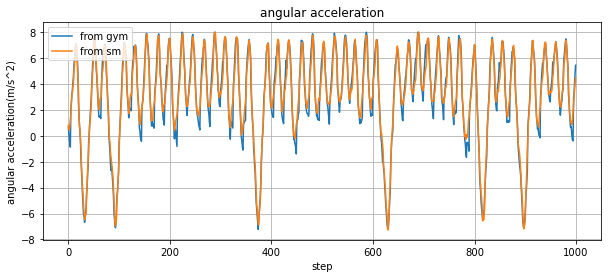

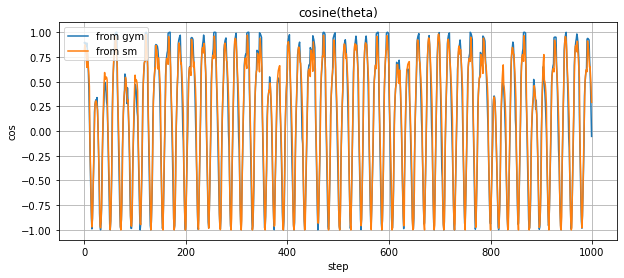

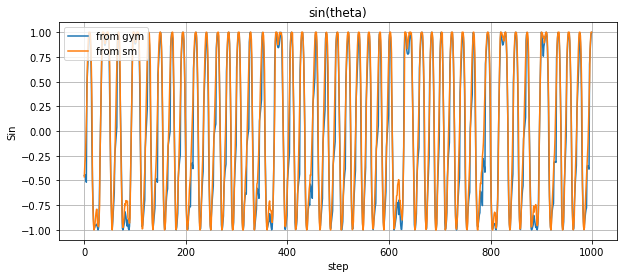

Number of correction done: 200
Number of entry in flag: 0


In [115]:
test(1000,5)

In [144]:
LSTMnet=rnn(data_train_file)
LSTMnet.train(1)

NameError: name 'rnn' is not defined